In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'; print(f"Running on {device}.")

Running on cpu.


The image the model will dream on

In [ ]:
!curl "https://img-datasets.s3.amazonaws.com/coast.jpg" -o source.jpg
!curl "https://img-datasets.s3.amazonaws.com/cat.jpg" -o cat.jpg

In [36]:
mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1).to(device)
std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1).to(device)

def preprocess(img_path):
    img = torchvision.io.read_image(img_path).float() / 255.0   # (channels, height, width)
    img = img.unsqueeze(0).to(device)                           # (batch, channels, height, width)
    img = (img - mean) / std                                    # normalize
    return img

def deprocess(img):
    img = img * std + mean                                      # denormalize
    img = img.squeeze(0).cpu().detach() * 255.0                 # (channels, height, width)
    img = img.permute(1, 2, 0).numpy().astype('uint8')          # (height, width, channels)
    return img

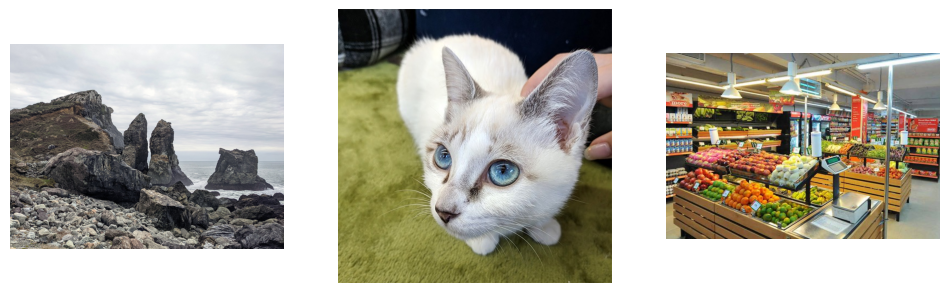

In [6]:
# the original images
image_files = ['inputs/coast.jpg', 'inputs/cat.jpg', 'inputs/supermarket.jpg']
fig, ax = plt.subplots(1, len(image_files), figsize=(12, 4))
for axis, image_file in zip(ax, image_files):
    axis.axis('off'); axis.imshow(torchvision.io.read_image(image_file).permute(1, 2, 0))

A pre-trained CNN - VGG19 trained on Imagenet dataset

In [30]:
pretrained_cnn = torchvision.models.vgg19(weights=torchvision.models.VGG19_Weights.IMAGENET1K_V1).to(device)
layers = list(pretrained_cnn.features.children())
model = nn.Sequential(*layers[:18]).to(device) # Extracting the first several layers of the VGG19 model

In [31]:
def dream(img:torch.tensor, model:nn.Module, iterations=50, lr=0.01):
    image = img.clone().detach().requires_grad_(True)

    for i in range(iterations):
        model.zero_grad()
        out = model(image)
        loss = torch.norm(out) # L2 norm
        loss.backward()

        grad = image.grad.data
        avg_grad = grad.abs().mean()  # average size of the gradient
        normalized_lr = lr / avg_grad # scale the lr by the average gradient magnitude

        image.data += normalized_lr * grad # gradient ascent step
        image.data = torch.clamp(image.data, -1, 1) # clip the image to be in the range [-(mean/std), (mean/std)]
        image.grad.data.zero_()

        if (i+1) % 10 == 0: print(f"  ↪ {i+1:3d}/{iterations} Overall Activity: {loss.item():.4f} Grad: {avg_grad.item():.4f}")
    
    return image

def deepdream(img:torch.tensor, model:nn.Module, iterations=50, lr=0.01, octave_scale=1.4, num_octaves=3):
    octaves = [img] # generate a list of octaves
    for _ in range(num_octaves-1):
        new_octave = F.interpolate(octaves[-1], scale_factor=(1/octave_scale), mode='bilinear', align_corners=False)
        octaves.append(new_octave)

    details = torch.zeros_like(octaves[-1])
    for i, octave in enumerate(octaves[::-1]):
        print(f"Octave {i+1}/{num_octaves} Shape: {tuple(octave.shape)}")

        # align the size of the details with the current octave
        if i > 0: details = F.interpolate(details, size=octave.shape[-2:], mode='bilinear', align_corners=False)
        
        new_input = octave + details                         # add details from the previous octave to the input
        dreamt_img = dream(new_input, model, iterations, lr) # optimize the image at this octave
        details = dreamt_img - octave                        # extract the details from the optimized image
    return dreamt_img

Octave 1/8 Shape: (1, 3, 46, 46)
  ↪  10/20 Loss: 1497.8970  Grad: 1.7216
  ↪  20/20 Loss: 1946.9275  Grad: 1.6641
Octave 2/8 Shape: (1, 3, 65, 65)
  ↪  10/20 Loss: 2500.6406  Grad: 1.2517
  ↪  20/20 Loss: 3080.5864  Grad: 1.1744
Octave 3/8 Shape: (1, 3, 92, 92)
  ↪  10/20 Loss: 3605.2844  Grad: 0.8210
  ↪  20/20 Loss: 4414.8779  Grad: 0.7855
Octave 4/8 Shape: (1, 3, 130, 130)
  ↪  10/20 Loss: 4863.6318  Grad: 0.5982
  ↪  20/20 Loss: 5958.0205  Grad: 0.5694
Octave 5/8 Shape: (1, 3, 182, 182)
  ↪  10/20 Loss: 6765.3594  Grad: 0.4365
  ↪  20/20 Loss: 8162.6494  Grad: 0.4155
Octave 6/8 Shape: (1, 3, 255, 255)
  ↪  10/20 Loss: 9327.2832  Grad: 0.3164
  ↪  20/20 Loss: 11363.0107  Grad: 0.3011
Octave 7/8 Shape: (1, 3, 357, 357)
  ↪  10/20 Loss: 13078.0703  Grad: 0.2290
  ↪  20/20 Loss: 15970.7344  Grad: 0.2158
Octave 8/8 Shape: (1, 3, 500, 500)
  ↪  10/20 Loss: 18169.7051  Grad: 0.1634
  ↪  20/20 Loss: 22190.8945  Grad: 0.1545


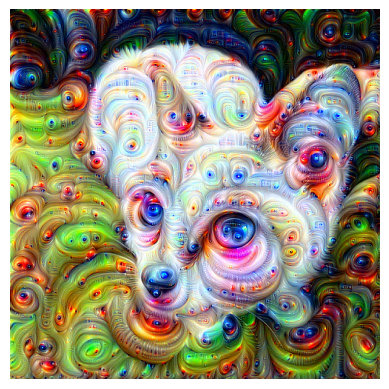

In [35]:
n_octaves = 8
iterations = 20
octave_scale = 1.4
lr = 0.01

input_img = preprocess('inputs/cat.jpg')
dream_img = deprocess(deepdream(input_img, model, iterations, lr, octave_scale, n_octaves))

plt.axis('off')
plt.imshow(dream_img)
plt.imsave('outputs/cat_out.jpg', dream_img)

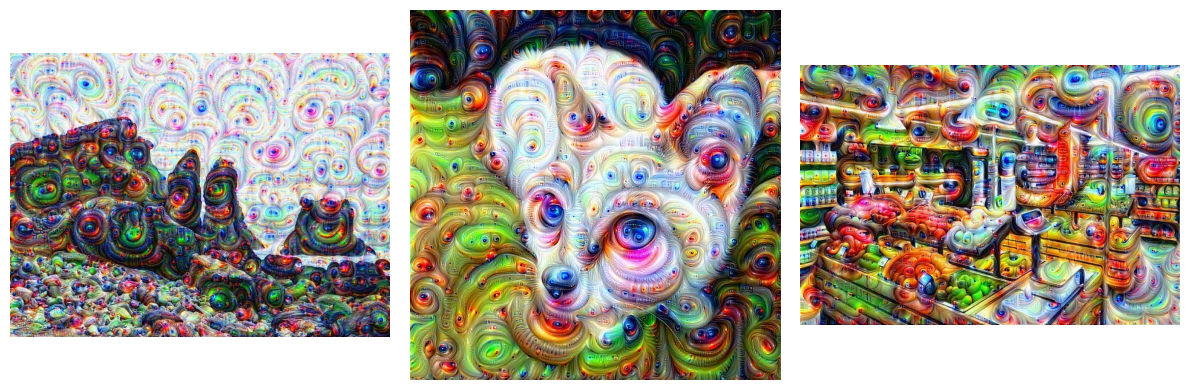

In [7]:
# the original images
image_files = ['outputs/coast_out.jpg', 'outputs/cat_out.jpg', 'outputs/supermarket_out.jpg']
fig, ax = plt.subplots(1, len(image_files), figsize=(12, 4))
for axis, image_file in zip(ax, image_files):
    axis.axis('off'); axis.imshow(torchvision.io.read_image(image_file).permute(1, 2, 0))

plt.tight_layout()